## Simulating the eBOSS Instrument

This notebook goes through how to simulate eBOSS spectra given a model spectrum. The model spectrum to be simulated is specified in the config file under `source/table/path`. In this example, we are simulating a 22.4 magnitude quasar spectrum at z=1.5. This corresponds to source files `{DESIMODEL}/data/spectra/spec-qso-z1.5-rmag22.24.dat` and `<PACKAGE_DATA>/sdss/spec-qso.dat` in DESI and eBOSS modes, respectively.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import specsim.simulator

from astropy.io import fits
from astropy.table import Table

#### Compare specsim output in DESI and eBOSS modes

##### Initialize each simulator

In [3]:
desi = specsim.simulator.Simulator('desi', num_fibers=1, camera_output=True)
eboss = specsim.simulator.Simulator('eboss', num_fibers=1, camera_output=True)

/Users/belaabolfathi/anaconda3/lib/python3.5/site-packages/speclite/filters.py:1466: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  values_no_units = values_no_units[values_slice]
/Users/belaabolfathi/anaconda3/lib/python3.5/site-packages/speclite/filters.py:1466: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  values_no_units = values_no_units[values_slice]


##### Get simulated output for each camera

In [4]:
def get_camera_output(simulator, seed=123, eboss=False):
    gen = np.random.RandomState(seed)
    # Simulate the response of the spectrograph
    simulator.simulate()
    # Generate a random realization of the instrumental noise
    simulator.generate_random_noise(gen)
    
    if eboss:
        return(simulator._eboss_camera_output)

    else:
        return(simulator.camera_output)
    
desi_g, desi_r, desi_z = get_camera_output(desi)
eboss_b, eboss_r = get_camera_output(eboss, eboss=True)

/Users/belaabolfathi/desi/code/specsim/specsim/simulator.py:590: RuntimeWarning: divide by zero encountered in true_divide
  source_flux_to_photons * camera.throughput.reshape(-1, 1)))
/Users/belaabolfathi/desi/code/specsim/specsim/simulator.py:594: RuntimeWarning: invalid value encountered in multiply
  output['flux_calibration'] * output['num_source_electrons'])


Let's look at the source models for each config mode:

In [5]:
# Load the model spectra
# DESI
qso_desi_path = os.path.join(os.getenv('DESIMODEL'), 'data/spectra/spec-qso-z1.5-rmag22.24.dat')
qso_desi_model = Table.read(qso_desi_path, format='ascii')
wlen_desi, flux_desi = qso_desi_model['WAVELENGTH'], qso_desi_model['FLUX']

# eBOSS
qso_eboss_path = os.path.join(os.getenv('SDSS'), 'spec-qso.dat')
qso_eboss_model = Table.read(qso_eboss_path, format='ascii')
wlen_eboss, flux_eboss = qso_eboss_model['WAVELENGTH'], qso_eboss_model['FLUX']

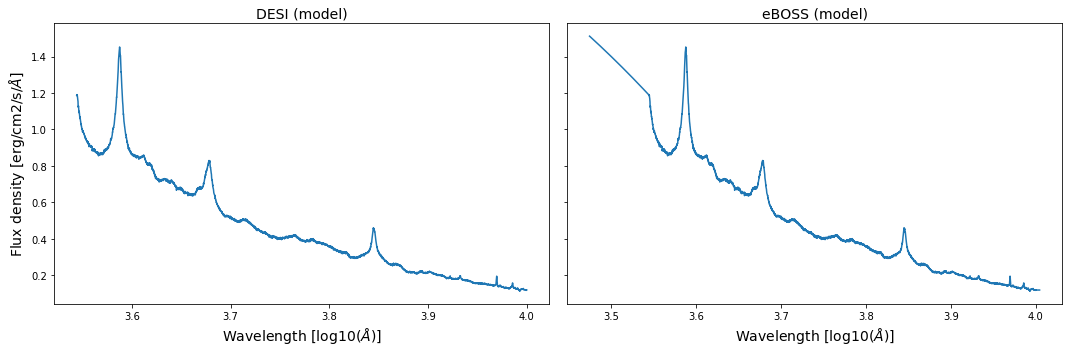

In [6]:
fs = 14

fig, axs = plt.subplots(1,2, figsize=(15,5), sharey=True)
axs = axs.ravel()
axs[0].plot(np.log10(qso_desi_model['WAVELENGTH']), qso_desi_model['FLUX'])
axs[1].plot(np.log10(qso_eboss_model['WAVELENGTH']), qso_eboss_model['FLUX'])

axs[0].set_title('DESI (model)', fontsize=fs)
axs[1].set_title('eBOSS (model)', fontsize=fs)
axs[0].set_xlabel('Wavelength [log10($\AA$)]', fontsize=fs)
axs[1].set_xlabel('Wavelength [log10($\AA$)]', fontsize=fs)
axs[0].set_ylabel('Flux density [erg/cm2/s/$\AA$]', fontsize=fs)

plt.tight_layout()
plt.show()

Now plot the simulated outputs (exclude first and last values in eBOSS output which are not properly handled):

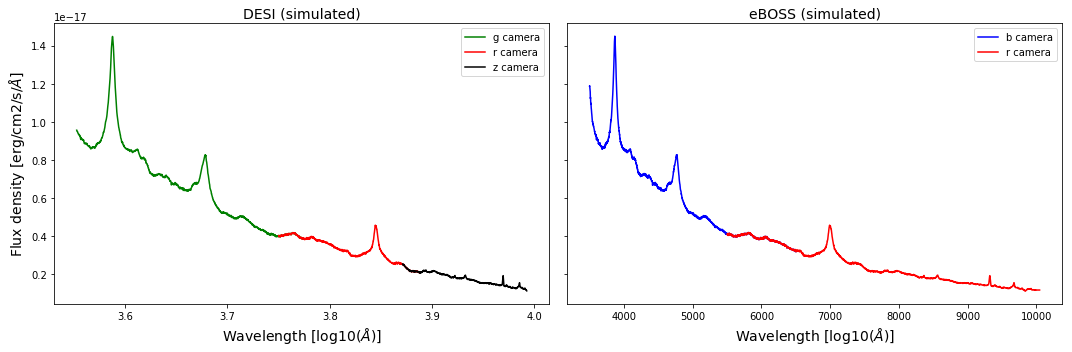

In [7]:
fs = 14

fig, axs = plt.subplots(1,2, figsize=(15,5), sharey=True)
axs = axs.ravel()
axs[0].plot(np.log10(desi_g['wavelength']), desi_g['observed_flux'], c='g', label='g camera')
axs[0].plot(np.log10(desi_r['wavelength']), desi_r['observed_flux'], c='r', label='r camera')
axs[0].plot(np.log10(desi_z['wavelength']), desi_z['observed_flux'], c='k', label='z camera')
axs[1].plot(eboss_b['wavelength'][1:-1], eboss_b['observed_flux'][1:-1], c='b', label='b camera')
axs[1].plot(eboss_r['wavelength'][1:-1], eboss_r['observed_flux'][1:-1], c='r', label='r camera')

axs[0].set_title('DESI (simulated)', fontsize=fs)
axs[1].set_title('eBOSS (simulated)', fontsize=fs)
axs[0].set_xlabel('Wavelength [log10($\AA$)]', fontsize=fs)
axs[1].set_xlabel('Wavelength [log10($\AA$)]', fontsize=fs)
axs[0].set_ylabel('Flux density [erg/cm2/s/$\AA$]', fontsize=fs)
axs[0].legend()
axs[1].legend()

plt.tight_layout()
plt.show()

##### Plot DESI and eBOSS simulated inverse variance

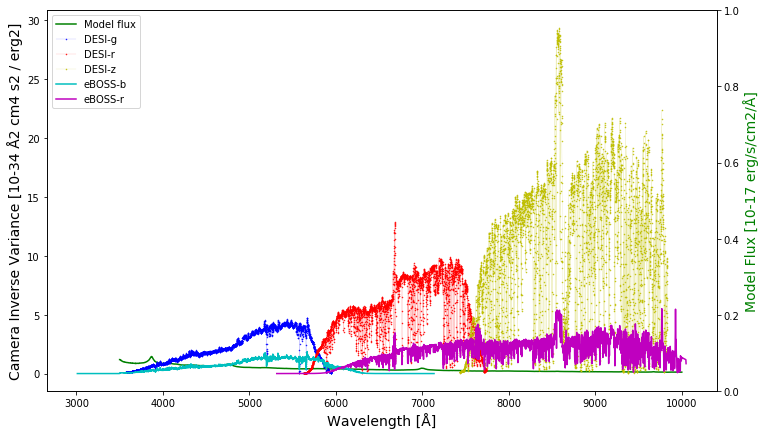

In [8]:
fs = 14

fig, ax1 = plt.subplots(figsize=(12,7))

ax2 = ax1.twinx()
ax1.plot(qso_desi_model['WAVELENGTH'], qso_desi_model['FLUX'], 'g', label='Model flux') # 1e-17 erg/s/cm2/A
ax1.plot(desi_g['wavelength'], desi_g['flux_inverse_variance'] * 1e-34, 'b.-', ms=1, lw=0.1, 
         label='DESI-g') # 1e34 A2 cm4 s2 / erg2
ax1.plot(desi_r['wavelength'], desi_r['flux_inverse_variance'] * 1e-34, 'r.-',  ms=1, lw=0.1, 
         label='DESI-r') # 1e34 A2 cm4 s2 / erg2
ax1.plot(desi_z['wavelength'], desi_z['flux_inverse_variance'] * 1e-34, 'y.-',  ms=1, lw=0.1, 
         label='DESI-z') # 1e34 A2 cm4 s2 / erg2
ax1.plot(eboss_b['wavelength'], eboss_b['flux_inverse_variance'] * 1e-34, 'c', label='eBOSS-b')
ax1.plot(eboss_r['wavelength'], eboss_r['flux_inverse_variance'] * 1e-34, 'm', label='eBOSS-r')

ax1.legend(loc=2)
ax1.set_xlabel('Wavelength [Å]', fontsize=fs)
ax1.set_ylabel('Camera Inverse Variance [10-34 Å2 cm4 s2 / erg2]', fontsize=fs)
ax2.set_ylabel('Model Flux [10-17 erg/s/cm2/Å]', color='g', fontsize=fs)
plt.show()